# Personal Information
Name: **Kim Tigchelaar**

StudentID: **12621803**

Email: [**kim.tigchelaar@student.uva.nl**](kim.tigchelaar@student.uva.nl)

Submitted on: **18.03.2024** 

# Data Context
In the field of aviation, aircraft maintenance is needed to ensure safety and usability of an airlines' fleet. While this is usually done in a preventitive way, with regularly scheduled check-ups and maintenance sessions where engine parts are updated or replaced, another way to do this is Predictive Aircraft Maintenance (PdM). With PdM, the Remaining Useful Life (RUL) of an aircraft's jet engine can be predicted and targeted maintenance can be executed, saving both time and money, and increasing aircraft safety. To do this, machine learning models need to be trained to detect anomalies in engine sensor data. However, as most real data is from healthy flights, there is a lack of anomaly data that indicates engine failure. To combat this issue, simulated data of a deteriorating jet engine can be used to train machine learning mdoels. A very useful dataset for this, is the N-CMAPSS turbofan engine dataset recently released by NASA, which includes high fidelity degradation modeling, real world operating conditions, and a large set of fault operating modes. During my thesis, I will be using the N-CMAPSS dataset to set-up a Federated Learning (FL) workflow for PdM.

# Data Description
The dataset consists of different subsets that contain multivariate timeseries data of a jet engine. The subsets are labeled DS01, DS02, DS03, DS04, DS05, DS06, DS07, DS08a, DS08c and DS08d. Data points are available for each second of a full flight cycle, for multiple cycles, until the end of life of the engines. The data is stored in h5-files. 

The available features can be roughly classified into four categories: 
1. <b>Operating Points</b> which are defined by Altitude, Mach Number and Throttle Resolver Angle. 
2. <b>Measured Parameters</b>, normally available in real life engines. 
3. <b>Virtual Measurements</b>, which include features in engine stations that are not available or need special sensors / models to be assessed. 
4. <b>Health Parameters</b>, that indicate efficiency and mass flow divergence for High Pressure Turbine (HPT) and Compressor (HPC), Low Pressure Turbine (LPT) and Compressor (LPC), as well as Fan.

Additionally, there is some auxiliary information available that for each row contains the engine unit number, the cycle number, the current health state, and the flight class. 

All subsets have a corresponding train and test set, as well as a vector of true RUL values data. Every row represents a snapshot of data captured during a single operational cycle of an engine. Data points are available for each second of a full flight cycle, for multiple cycles, until the end of life of the engines. The engine is operating normally at the start of each time series and develops a fault at some point during the series.


In [176]:
# imports 
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame
from matplotlib import gridspec
%matplotlib inline

# Data Loading

In [177]:
# using the DS02 subset for this EDA
filename = 'N-CMAPSS_DS02-006.h5'

In [178]:
# time tracking
t = time.process_time()  

# loading data
with h5py.File(filename, 'r') as hdf:
        
        # development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.03549015000000016

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [179]:
# creating the dataframes
df_A = DataFrame(data=A, columns=A_var)             # auxiliary information
df_W = DataFrame(data=W, columns=W_var)             # operative conditions 
df_X_s = DataFrame(data=X_s, columns=X_s_var)       # sensor readings
df_X_v = DataFrame(data=X_v, columns=X_v_var)       # virtual sensors
df_T = DataFrame(data=T, columns=T_var)             # degradation
df_Y = DataFrame(data=Y)                            # RUL

# concatinated DataFrame 
df = pd.concat([df_W, df_X_s, df_X_v, df_T, df_Y, df_A], axis=1)

In [180]:
features_list = df_A.columns.to_list() + df_W.columns.to_list() + df_X_s.columns.to_list() + df_X_v.columns.to_list() + df_T.columns.to_list()
no_of_features = len(features_list)
no_of_rows = df_A.shape[0]
no_of_datapoints = no_of_rows * (no_of_features - 3)    # not counting the unit, cycle and flight class

print(f"The DS02 subset of the N-CMAPSS Dataset contains {no_of_features} features.")
print(f"The DS02 subset of the N-CMAPSS Dataset contains {no_of_rows} rows, with a total of {no_of_datapoints} datapoints.")

The DS02 subset of the N-CMAPSS Dataset contains 46 features.
The DS02 subset of the N-CMAPSS Dataset contains 6517190 rows, with a total of 280239170 datapoints.


# Feature Descriptions

All subsets of the N-CMAPSS Dataset include the features described below (excluding the degradation measurements). 

**Measurements**
| Feature | Description | 
|:--------:| :-------|
|  Alt   |  Altitude   |
|  T2   |  Total temp. at Fan Inlet   |
|  T24   |  Total temp. at LPC Outlet   |
| T50 | Total Temp. at LPT Outlet |
| P24 | Total Pres. at LPC Outlet |
| P50 | Total Pres. at LPT Outlet |
| Mach | Flight Mach Number |
| P2 | Total Pres. at Fan Inlet |
| T30 | Total Temp. at HPC Outlet |
| P15 | Total Pres. at By-pass Duct |
| Ps30 | Static Pres. at HPC Outlet |
| Nf | Physical Fan Speed |
| TRA | Throttle Resolver Angle |
| Wf | Fuel Flow |
| T48 | Total Temp. at HPT Outlet |
| P21 | Total Pres. at Fan Outlet |
| P40 | Total Pres. at Burner Outlet |
| Nc | Physical Core Speed |

\
**Virtual**
| Feature | Description | 
|:--------:| :-------|
| T40 | Total Temp. at Burner Outlet |
| W21 | Fan Flow |
| W31 | HPT Coolant Bleed |
| W50 | Flow Out of LPT |
| SmHPC | HPC Stall Margin |
| P30 | Total Pres. at HPC Outlet |
| W22 | Flow out of LPC |
| W32 | HPT Coolant Bleed |
| SmFan | Fan Stall Margin |
| phi | Ratio of fuel flow to Ps30 |
| P45 | Total Pres. at HPT Outlet |
| W25 | Flow into HPC |
| W48 | Flow Out of HPT 
| SmLPC | LPC Stall Margin |


As the N-CMAPSS Dataset is simulated, the dataset contains zero missing or NaN values:

In [181]:
null_df = df.apply(lambda x: sum(x.isnull())).to_frame(name="count")
print(null_df)

              count
alt               0
Mach              0
TRA               0
T2                0
T24               0
T30               0
T48               0
T50               0
P15               0
P2                0
P21               0
P24               0
Ps30              0
P40               0
P50               0
Nf                0
Nc                0
Wf                0
T40               0
P30               0
P45               0
W21               0
W22               0
W25               0
W31               0
W32               0
W48               0
W50               0
SmFan             0
SmLPC             0
SmHPC             0
phi               0
fan_eff_mod       0
fan_flow_mod      0
LPC_eff_mod       0
LPC_flow_mod      0
HPC_eff_mod       0
HPC_flow_mod      0
HPT_eff_mod       0
HPT_flow_mod      0
LPT_eff_mod       0
LPT_flow_mod      0
0                 0
unit              0
cycle             0
Fc                0
hs                0


## Auxiliary Information (df $A$)

In [182]:
# show first 3 rows
df_A[:3]

,unit,cycle,Fc,hs
0,2.0,1.0,3.0,1.0
1,2.0,1.0,3.0,1.0
2,2.0,1.0,3.0,1.0


### Engine Units

In [183]:
# extracting the engine units in this subset
print('Engine units in df: ', np.unique(df_A['unit']))

Engine units in df:  [ 2.  5. 10. 11. 14. 15. 16. 18. 20.]


### Flight Classes

The units are divided into three flight classes depending on whether the unit is operating short-length flights (i.e., flight class 1), medium-length flights (i.e., flight class 2), or long-length flights (i.e., flight class 2). A number of real flight conditions are available within each of the flight classes.

| Flight Class   | Flight Length (in hours)
| :-----------:  | :-----------:    
| 1              |    1 to 3        
| 2              |    3 to 5        
| 3              |    5 to 7        


Text(0.5, 1.0, 'The flight class of each engine unit')

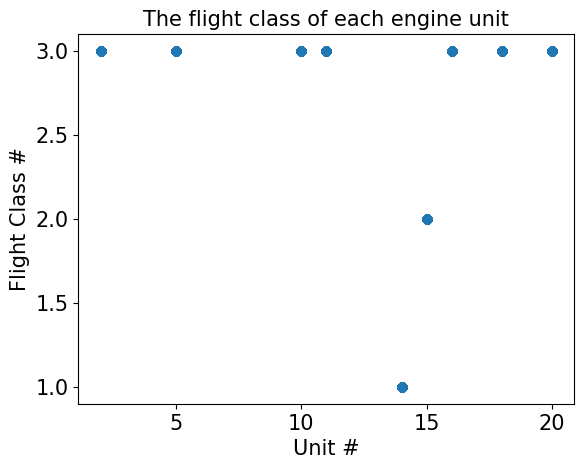

In [184]:
labelsize = 15
plt.plot(df_A.unit, df_A.Fc, 'o')
plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.xlabel('Unit #', fontsize=labelsize)
plt.ylabel('Flight Class #', fontsize=labelsize )
plt.title("The flight class of each engine unit", fontsize=labelsize)

### End Of Failure ($t_{\text{EOF}}$)

The run to failure operation take a different number of cycles for each unit. Reported below is the total number of cycles for each unit in subset DS02.

In [185]:
for i in np.unique(df_A['unit']):
    print('Unit: ' + str(i) + ' - Number of flight cyles (t_EOF): ', len(np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])))
    #np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])

Unit: 2.0 - Number of flight cyles (t_EOF):  75
Unit: 5.0 - Number of flight cyles (t_EOF):  89
Unit: 10.0 - Number of flight cyles (t_EOF):  82
Unit: 11.0 - Number of flight cyles (t_EOF):  59
Unit: 14.0 - Number of flight cyles (t_EOF):  76
Unit: 15.0 - Number of flight cyles (t_EOF):  67
Unit: 16.0 - Number of flight cyles (t_EOF):  63
Unit: 18.0 - Number of flight cyles (t_EOF):  71
Unit: 20.0 - Number of flight cyles (t_EOF):  66


So for example, unit number 2.0 has flight class 3 and runs to failure in 75 cycles. We can also see that 7 out 9 units in this subset have flight class 3, one of them has flight class 2 and one of them has flight class 1.

### Average Flight Duration per Engine

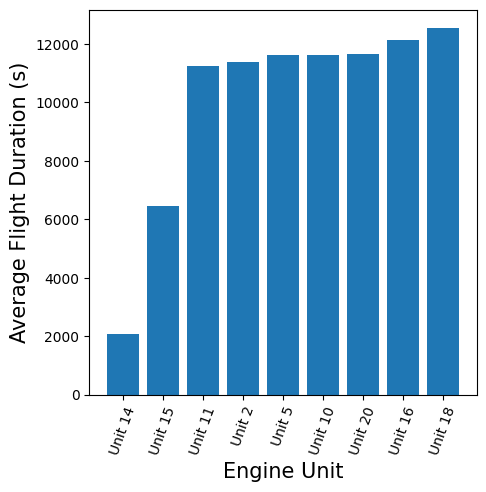

In [186]:
# average flight time per cycle (flight)
avg_time_dict = {}

for i in np.unique(df_A['unit']):
    temp_num_cycles = len(np.unique(df_A.loc[df_A['unit'] == i, 'cycle']))
    df_unit_temp =  df[df['unit'] == np.float64(i)]
    temp_avg_time = int(df_unit_temp.shape[0]/temp_num_cycles)
    avg_time_dict['Unit '+ str(int(i))] = temp_avg_time

avg_time_dict = dict(sorted(avg_time_dict.items(), key=lambda item: item[1]))

fig = plt.figure(figsize=(5, 5))  
plt.bar(list(avg_time_dict.keys()), avg_time_dict.values())
plt.yticks(fontsize=10)
plt.xticks(rotation=70, fontsize=10)
plt.ylabel('Average Flight Duration (s)' , fontdict = {'fontsize' : 15})
plt.xlabel('Engine Unit' , fontdict = {'fontsize' : 15})
plt.show()

## Operative Conditions (df $w$)

In [187]:
# adding unit column to df_W
df_W['unit'] = df_A['unit'].values

# show first 3 rows
df_W[:3]

,alt,Mach,TRA,T2,unit
0,10005.0,0.448497,76.903748,502.420918,2.0
1,10013.0,0.447741,76.903748,502.326114,2.0
2,10017.0,0.448938,77.079529,502.416067,2.0


**Helper Functions for Plots**

In [188]:
def plot_df_single_color(data, variables, labels, size=12, labelsize=15, name=None):

    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)    
    fig  = plt.figure(figsize=(size,max(size,rows*2))) 
    
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        ax.plot(data[variables[n]], marker='.', markerfacecolor='none', alpha = 0.7)
        ax.tick_params(axis='x', labelsize=labelsize)
        ax.tick_params(axis='y', labelsize=labelsize)
        plt.ylabel(labels[n], fontsize=labelsize)
        plt.xlabel('Time [s]', fontsize=labelsize)
    plt.tight_layout()

    if name is not None:
        plt.savefig(name, format='png', dpi=300)

    plt.show()
    plt.close()

In [189]:
def plot_df_color_per_unit(data, variables, labels, size=7, labelsize=15, option='Time', name=None):

    plt.clf()        
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs   = gridspec.GridSpec(rows, cols)
    leg  = []
    fig  = plt.figure(figsize=(size,max(size,rows*2)))
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    unit_sel  = np.unique(data['unit'])
    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for j in unit_sel:
            data_unit = data.loc[data['unit'] == j]
            if option=='cycle':
                time_s = data.loc[data['unit'] == j, 'cycle']
                label_x = 'Time [cycle]'
            else:
                time_s = np.arange(len(data_unit))
                label_x = 'Time [s]'
            ax.plot(time_s, data_unit[variables[n]], '-o', color=color_dic_unit['Unit ' + str(int(j))],
                    alpha=0.7, markersize=5)
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
            leg.append('Unit '+str(int(j)))
        plt.ylabel(labels[n], fontsize=labelsize)    
        plt.xlabel(label_x, fontsize=labelsize)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        if n==0:
            ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend(leg, loc='best', fontsize=labelsize-2) #lower left
    plt.tight_layout()

    if name is not None:
        plt.savefig(name, format='png', dpi=300)   

    plt.show()
    plt.close()

### Flight Traces

The variations in the data during a flight can be visualized clearly. For example, the following plot shows the flight characteristics of a flight from unit 10 during cycle 18.

<Figure size 640x480 with 0 Axes>

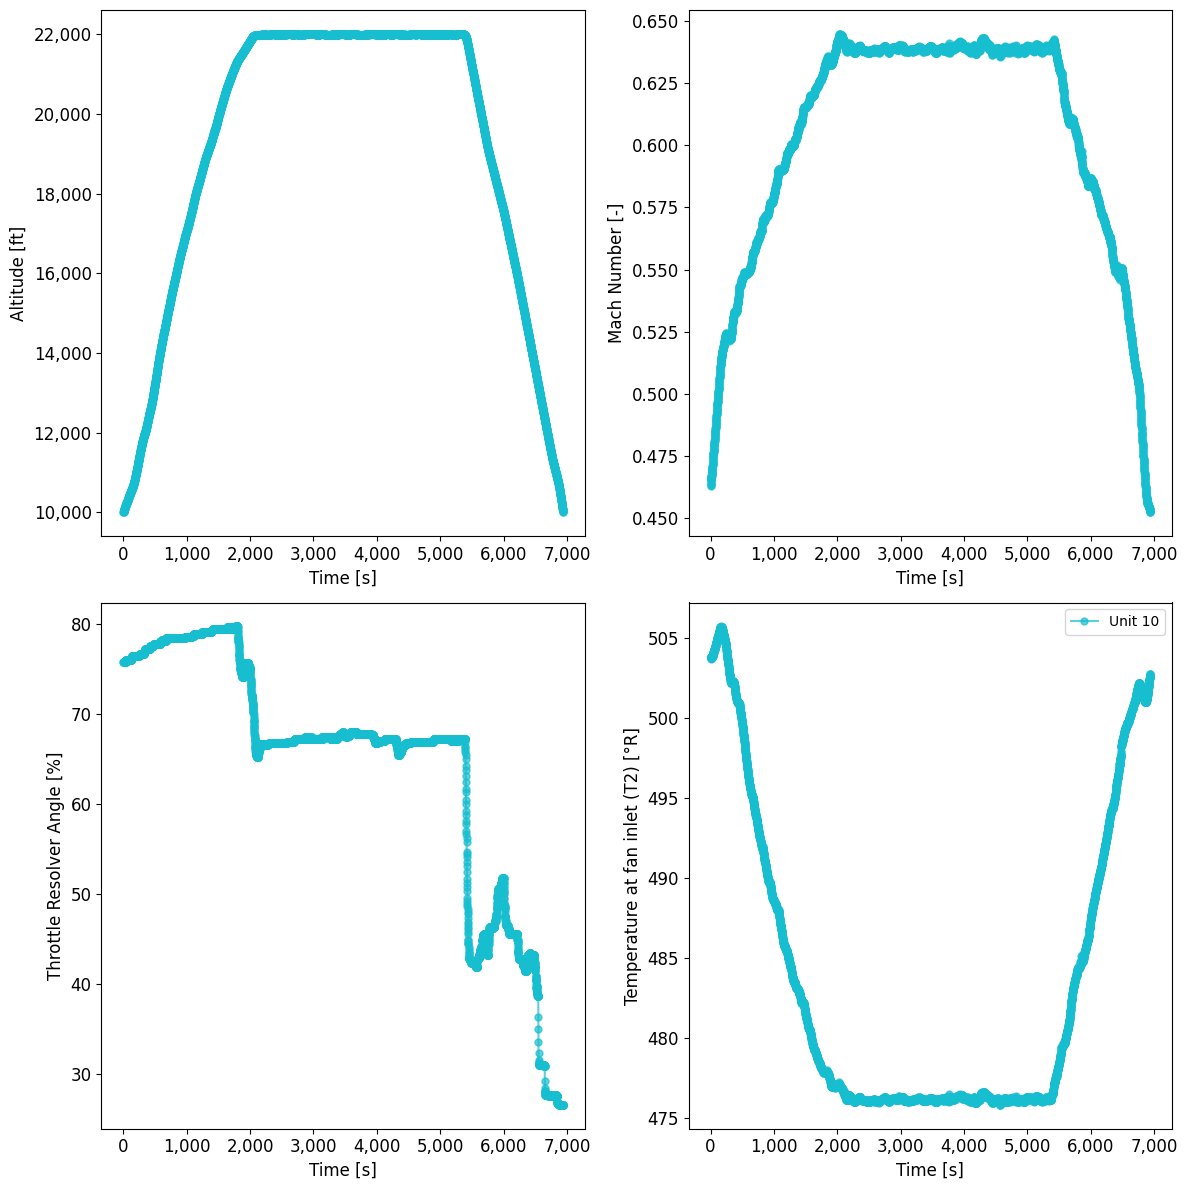

In [190]:
df_W_u = df_W.loc[(df_A.unit == 10) & (df_A.cycle == 18)]
df_W_u.reset_index(inplace=True, drop=True)

labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet (T2) [°R]']
plot_df_color_per_unit(df_W_u, W_var , labels, size=12, labelsize=12)

### Flight Envelope

In aerodynamics, the flight envelope defines operational limits for an aircaft with respect to maximum speed and load factor given a particular atmospheric density. In other words, the flight envelope is the region within which an aircraft can operate safely. In this case, the flight envelope is visualized by plotting the Flight Altitude against the Mach Number for all instances of fligh classes 1, 2, and 3. 

Text(0, 0.5, 'Flight Altitude [ft]')

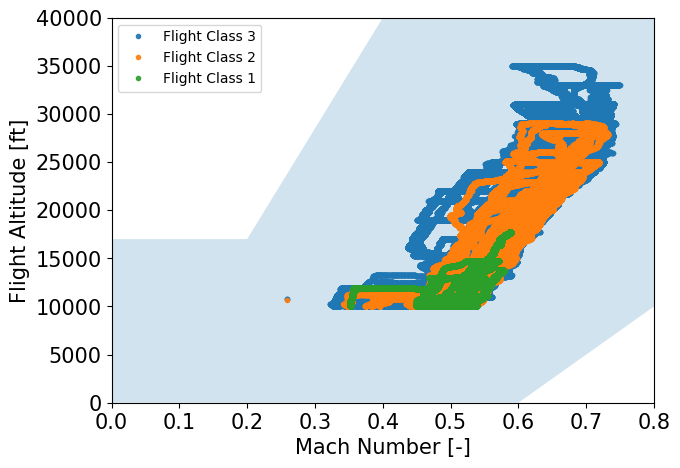

In [191]:
labelsize = 15

# initializing pre-determined outer constraints
x = np.array([0.0, 0.2, 0.4, 0.6, 0.8])
u = np.array([1.7, 1.7, 4.0, 4.0, 4.0])*10000
l = np.array([0.0, 0.0, 0.0, 0.0, 1.0])*10000

plt.figure(figsize=(7,5)) 
plt.fill_between(x, l, u, alpha=0.2)

# selecting instances of flight classes 1, 2, and 3 seperately
plt.plot(df_W.loc[df_A['Fc'] == 3, 'Mach'], df_W.loc[df_A['Fc'] == 3, 'alt'], '.', alpha=0.9, label = "Flight Class 3")
plt.plot(df_W.loc[df_A['Fc'] == 2, 'Mach'], df_W.loc[df_A['Fc'] == 2, 'alt'], '.', alpha=0.9, label = "Flight Class 2")
plt.plot(df_W.loc[df_A['Fc'] == 1, 'Mach'], df_W.loc[df_A['Fc'] == 1, 'alt'], '.', alpha=0.9, label = "Flight Class 1")

plt.tick_params(axis='x', labelsize=labelsize )
plt.tick_params(axis='y', labelsize=labelsize )
plt.legend(loc="upper left")
plt.xlim((0.0, 0.8))
plt.ylim((0, 40000)) 
plt.xlabel('Mach Number [-]', fontsize=labelsize)
plt.ylabel('Flight Altitude [ft]', fontsize=labelsize)


### Flight Conditions

In stead of looking at one engine unit at the time, the flight conditions can also be visualized for all units at once.

In [192]:
def plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=15, name=None):

    plt.clf()
       
    input_dim = len(variables)
    cols = min(np.floor(input_dim**0.5).astype(int),4)
    rows = (np.ceil(input_dim / cols)).astype(int)
    gs = gridspec.GridSpec(rows, cols)
    
    color_dic_unit = {'Unit 1': 'C0', 'Unit 2': 'C1', 'Unit 3': 'C2', 'Unit 4': 'C3', 'Unit 5': 'C4', 'Unit 6': 'C5',
                      'Unit 7': 'C6', 'Unit 8': 'C7', 'Unit 9': 'C8', 'Unit 10': 'C9', 'Unit 11': 'C10',
                      'Unit 12': 'C11', 'Unit 13': 'C12', 'Unit 14': 'C13', 'Unit 15': 'C14', 'Unit 16': 'C15',
                      'Unit 17': 'C16', 'Unit 18': 'C17', 'Unit 19': 'C18', 'Unit 20': 'C19'} 
    
    fig = plt.figure(figsize=(size,max(size,rows*2)))       

    for n in range(input_dim):
        ax = fig.add_subplot(gs[n])
        for k, elem in enumerate(units):
            sns.kdeplot(df_W.loc[df_A['unit'] == elem, variables[n]],
                        color=color_dic_unit[leg[k]], fill=True, gridsize=100)  
            ax.tick_params(axis='x', labelsize=labelsize)
            ax.tick_params(axis='y', labelsize=labelsize)
        
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))        
        plt.xlabel(labels[n], fontsize=labelsize)
        plt.ylabel('Density', fontsize=labelsize)
        if n==0:
            plt.legend(leg, fontsize=labelsize-4, loc=0)
        else:
            plt.legend(leg, fontsize=labelsize-4, loc=2)
    plt.tight_layout()

    if name is not None:
        plt.savefig(name, format='png', dpi=300)
            
    plt.show()
    plt.close()

**Kernel Density Estimate (KDE) plot**

<Figure size 640x480 with 0 Axes>

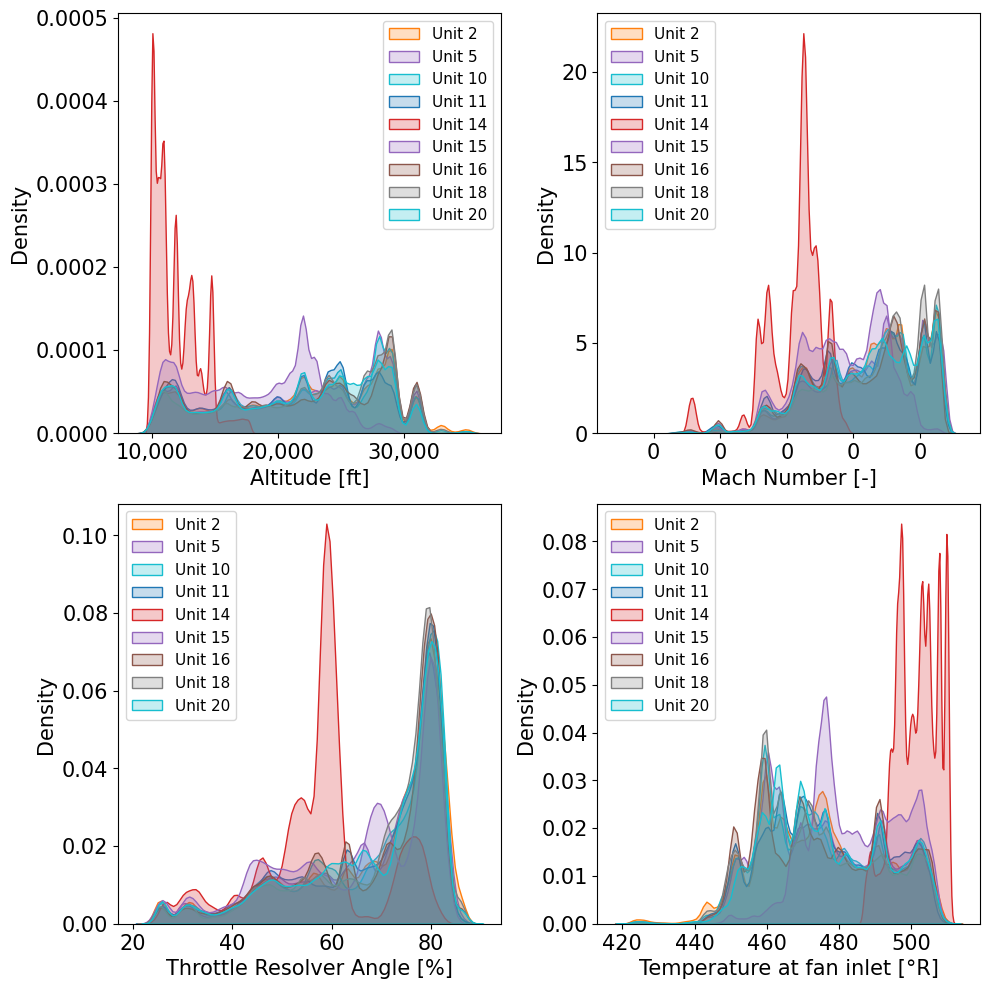

In [193]:
variables = ['alt', 'Mach', 'TRA', 'T2']
labels = ['Altitude [ft]', 'Mach Number [-]', 'Throttle Resolver Angle [%]', 'Temperature at fan inlet [°R]']
size = 10

units = list(np.unique(df_A['unit']))
leg = ['Unit ' + str(int(u)) for u in units]

plot_kde(leg, variables, labels, size, units, df_W, df_A, labelsize=15)

### Health state ($h_s$)

For each engine unit, its RUL is reduced to zero at different points in time (in other words, after a different amount of cycles). Let's see how the total amount of cycles is distributed across the engine units:

<Figure size 640x480 with 0 Axes>

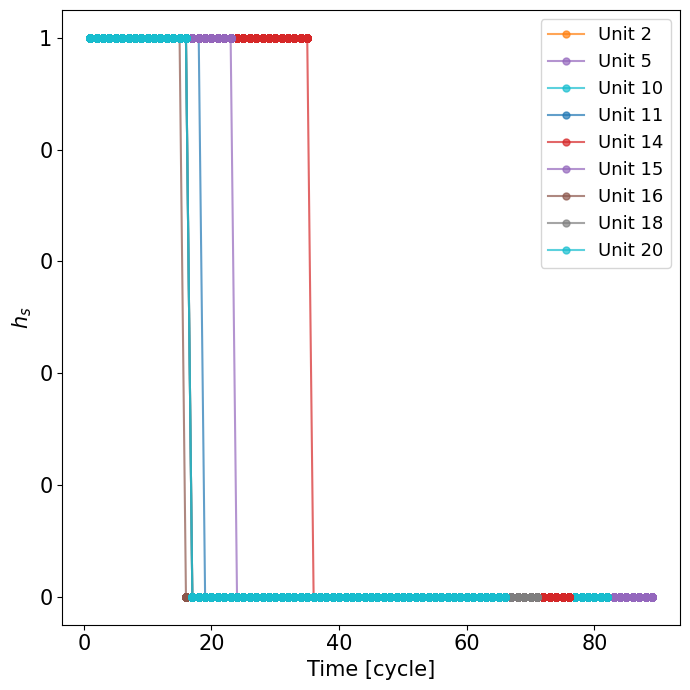

In [194]:
plot_df_color_per_unit(df_A, ['hs'], [r'$h_s$'], option='cycle')

Let's see to what extent, inter alia, the health state of an engine unite correlates to the RUL.

Text(0.5, 1.0, 'Auxiliary Info Correlations with RUL')

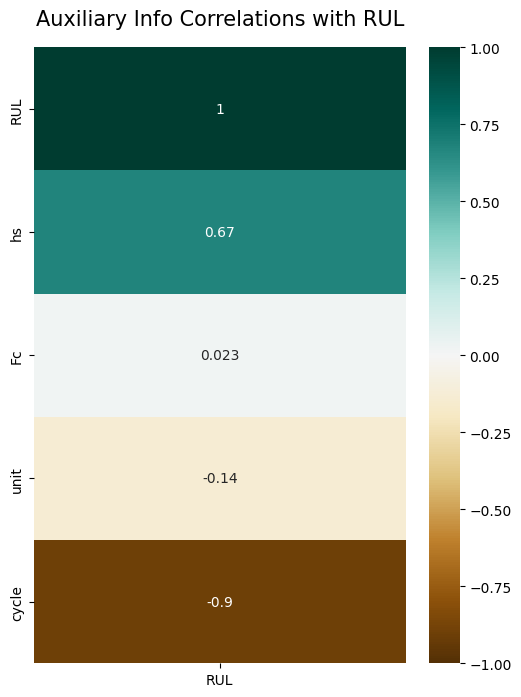

In [195]:
df_A['RUL'] = df_Y

# correlation heatmap of RUL against auxiliary information measurements
plt.figure(figsize=(6, 8))
sensor_readings_heatmap = sns.heatmap(df_A.corr()[['RUL']].sort_values(by='RUL', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
sensor_readings_heatmap.set_title('Auxiliary Info Correlations with RUL', fontdict={'fontsize':15}, pad=16)

As expected, the health state of an engine unit has a relatively high correlation with the RUL.

## Degradation (df $\theta$)

For each engine unit, health condition parameters for each of the ten failure modes are included in the data set. 

In [196]:
# show first 3 rows of df_T
df_T[:3]

,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000638,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-0.000638,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,-0.000638,0.0,0.0,0.0


Let's see to what extent the health parameters correlate to the RUL.

In [197]:
df_T['unit'] = df_A['unit'].values
df_T['cycle'] = df_A['cycle'].values
df_T['RUL'] = df_Y
df_Ts = df_T.drop_duplicates()

Text(0.5, 1.0, 'Health Parameters Correlating with RUL')

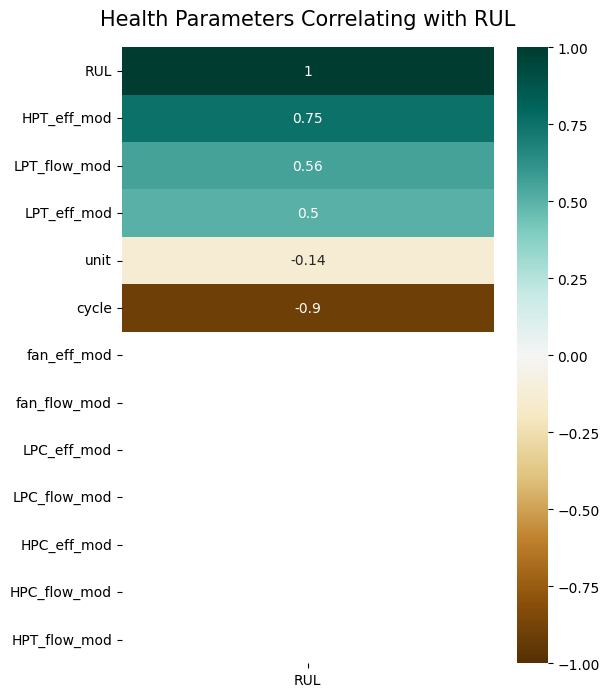

In [198]:
# correlation heatmap of RUL against health parameters
plt.figure(figsize=(6, 8))
RUL_heatmap = sns.heatmap(df_T.corr()[['RUL']].sort_values(by='RUL', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
RUL_heatmap.set_title('Health Parameters Correlating with RUL', fontdict={'fontsize':15}, pad=16)


As we can see, the "HPT_eff_mod" feature has the highest correlation with the RUL. Let's see how this feature develops itself per engine unit across each cycle.

<Figure size 640x480 with 0 Axes>

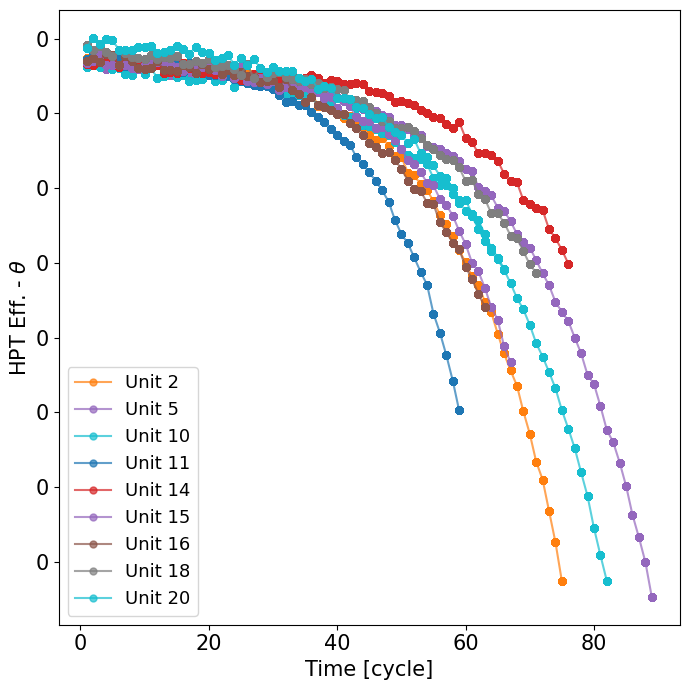

In [199]:
plot_df_color_per_unit(df_T, ['HPT_eff_mod'], [r'HPT Eff. - $\theta$'], size=7,  option='cycle')

## Sensor readings ($X_s$)

For each cycle of each unit, sensor readings are stored in the dataset. If we look again at the example from before (engine unit 10 and cycle 18), we can see how the data is distributed below:

<Figure size 640x480 with 0 Axes>

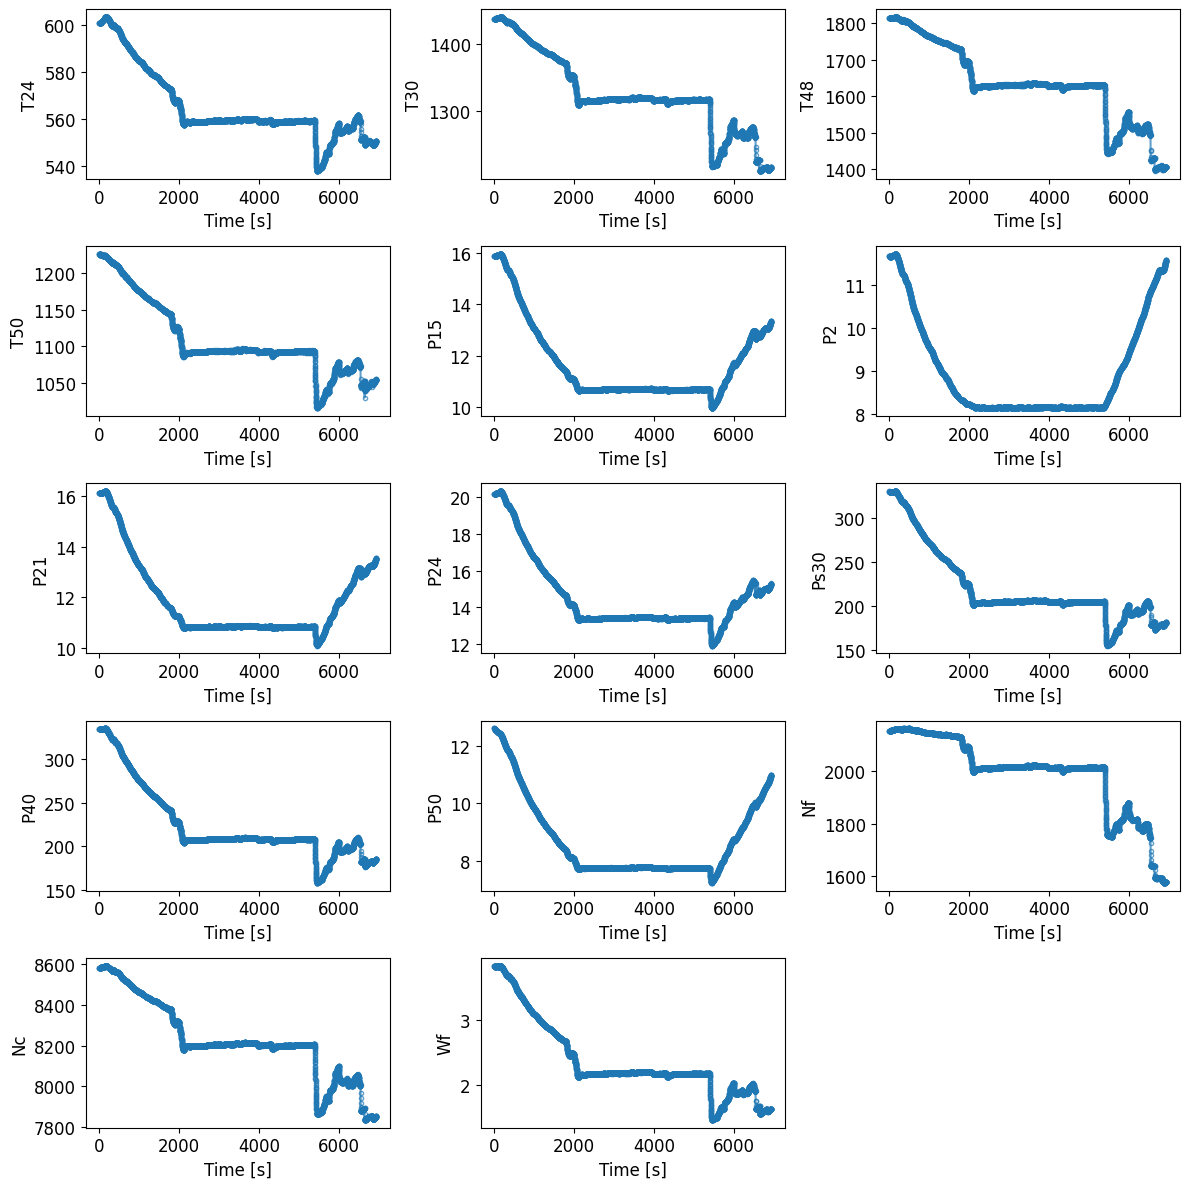

In [200]:
# selecting (unit 10, cycle 18) from the sensor readings dataframe
df_X_s_u = df_X_s.loc[(df_A.unit == 10) & (df_A.cycle == 18)]
df_X_s_u.reset_index(inplace=True, drop=True)

labels = X_s_var
plot_df_single_color(df_X_s_u, X_s_var , labels, size=12, labelsize=12)

Let's see to what extent the sensor readings correlate to the RUL.

In [201]:
df_X_s['unit'] = df_A['unit'].values
df_X_s['cycle'] = df_A['cycle'].values
df_X_s['RUL'] = df_Y

Text(0.5, 1.0, 'Sensor Readings Correlating with RUL')

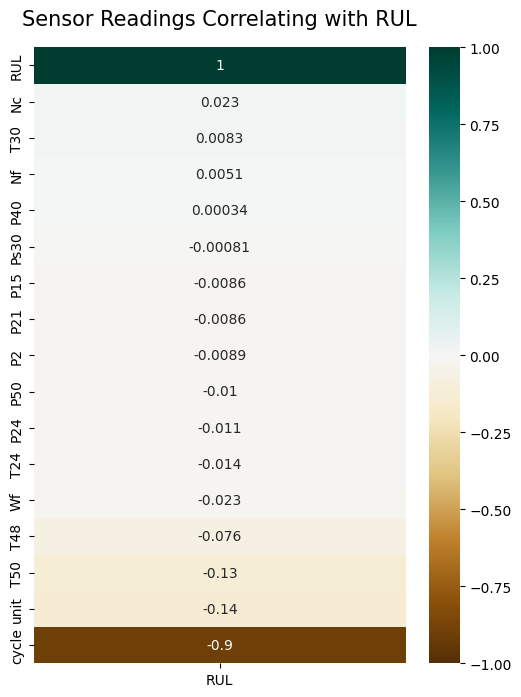

In [202]:
# correlation heatmap of RUL against sensor readings
plt.figure(figsize=(6, 8))
sensor_readings_heatmap = sns.heatmap(df_X_s.corr()[['RUL']].sort_values(by='RUL', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
sensor_readings_heatmap.set_title('Sensor Readings Correlating with RUL', fontdict={'fontsize':15}, pad=16)

There does not seem to be a high correlation between any of the sensor readings and the RUL.

## Virtual Sensors ($X_v$)

For each cycle of each unit, virtual sensor measurements are stored in the dataset. If we look at the example from before once more (engine unit 10 and cycle 18), we can see how the data is distributed below:

<Figure size 640x480 with 0 Axes>

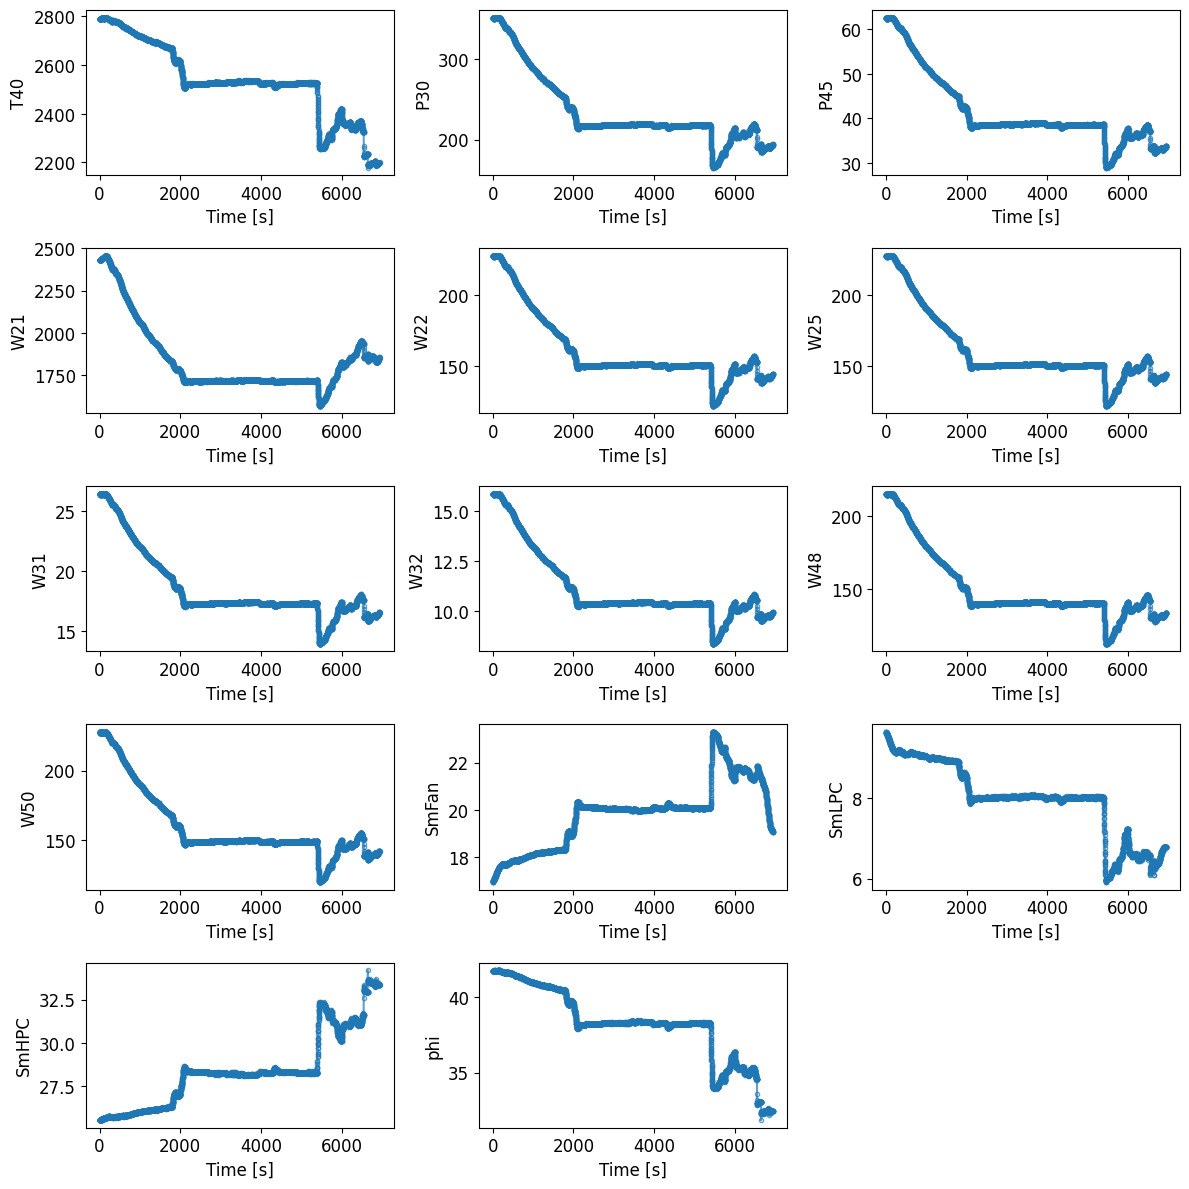

In [203]:
# selecting (unit 10, cycle 18) from the virtual sensors dataframe
df_X_v_u = df_X_v.loc[(df_A.unit == 10) & (df_A.cycle == 18)]
df_X_v_u.reset_index(inplace=True, drop=True)

labels = X_v_var
plot_df_single_color(df_X_v_u, X_v_var , labels, size=12, labelsize=12)

Let's see to what extent the virtual sensor measurements correlate to the RUL.

In [204]:
df_X_v['unit'] = df_A['unit'].values
df_X_v['cycle'] = df_A['cycle'].values
df_X_v['RUL'] = df_Y

Text(0.5, 1.0, 'Sensor Readings Correlating with RUL')

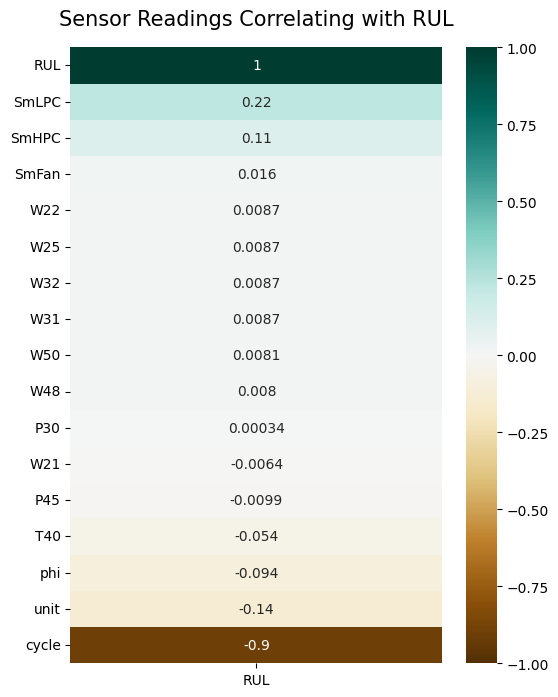

In [205]:
# correlation heatmap of RUL against virtual sensor measurements
plt.figure(figsize=(6, 8))
sensor_readings_heatmap = sns.heatmap(df_X_v.corr()[['RUL']].sort_values(by='RUL', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
sensor_readings_heatmap.set_title('Sensor Readings Correlating with RUL', fontdict={'fontsize':15}, pad=16)

Again, there does not seem to be much of a correlation between any of the virtual sensor measurements and the RUL, except for maybe the "SmLPC" feature with a relatively low correlation of 0.22.